In [1]:
## lets import necessary packages
## conda env compare_PSD
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import scipy.stats as stats
from statistics import mean


In [2]:
full_df_NO = pd.read_pickle("full_df_2021_NOX.pkl")

## This the data cleaning. Keeping only the relevant features and removing the less than equal to zero target values
cols=[i for i in range(2,28) ]
cols.append(0)

df1= full_df_NO.drop(full_df_NO.columns[cols], axis=1)
df2 = df1.drop(df1.columns[[2,3,4,5,6,9]], axis=1) 
j=[]

for i in range(4,72):
    j.append(i)
df3 = df2.drop(df2.columns[j], axis=1) 
df4 = df3.drop(df3.columns[[11,12,13,14,15,16,17,18]], axis=1) 
df4 = df4.drop(df3.columns[[6]], axis=1) 
df4.rename(columns={ 'NO': 'NO (ppb)','pda': 'Average Pupil Diameter (mm)', 'pup_dis': 'Pupil Distance (mm)',
                     'pd_diff': 'Difference in Pupil Diameter (mm)', 'ECG.': 'ECG (V)',
                     'Resp.': 'Respiration Rate (brpm)', 'Temp.': r'Skin Temperature ($\mathrm{^o C})$',
                     'HR': 'Heart Rate (bpm)','SpO2':r'$\mathrm{SpO_2}$ (%)','GSR':r'GSR ($\mathrm{\mu S}$)'},
                      inplace=True)

df_final = df4[df4['NO (ppb)'] >0]

## Lets change some of variables to standard units

pd.options.mode.chained_assignment = None ## apparently this needs to be added to overcome an error i dont understand  

df_final[r'$\mathrm{SpO_2}$ (%)']=df_final[r'$\mathrm{SpO_2}$ (%)']*1000000 ## change the SpO2 to percentage
df_final[r'GSR ($\mathrm{\mu S}$)']=df_final[r'GSR ($\mathrm{\mu S}$)']*1000 ## convert kiloohms to ohms
## convert ohms to siemans by taking the reciprocal
df_final[r'GSR ($\mathrm{\mu S}$)']=1/df_final[r'GSR ($\mathrm{\mu S}$)']  
df_final[r'GSR ($\mathrm{\mu S}$)']=df_final[r'GSR ($\mathrm{\mu S}$)']*1000000 ## convert siemens to microsiemens
df_final

j=[]
for i in range(10,330):
    j.append(i)
df_final = df_final.drop(df_final.columns[j], axis=1) 
df_final


,NO (ppb),Average Pupil Diameter (mm),Pupil Distance (mm),Difference in Pupil Diameter (mm),ECG (V),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$
dateTime,,,,,,,,,,
2021-05-26 11:52:14.898927,0.1,3.235,66.06,-0.01,-0.001403,41.631553,99.0,118.0,0.078621,29.5625
2021-05-26 11:52:19.881416,0.8,3.060,65.49,0.06,-0.001208,40.439460,99.0,116.0,0.079237,29.5625
2021-05-26 11:52:24.902444,1.4,3.060,65.52,0.24,-0.001088,40.072661,100.0,116.0,0.079105,29.5000
2021-05-26 11:52:29.892316,2.1,3.170,65.75,0.14,-0.000844,38.880568,99.0,118.0,0.079083,29.5000
2021-05-26 11:52:39.897584,3.6,3.175,65.54,0.15,-0.000421,38.192824,97.0,122.0,0.078884,29.4375
...,...,...,...,...,...,...,...,...,...,...
2021-06-10 11:26:26.068698,35.7,2.750,65.90,0.02,-0.001450,28.931178,97.0,120.0,0.091122,29.3750
2021-06-10 11:26:31.056772,43.9,2.595,65.29,0.11,-0.001048,29.297976,96.0,120.0,0.091181,29.3750
2021-06-10 11:26:41.060407,6.8,2.615,66.04,0.05,-0.001223,27.463986,96.0,122.0,0.091682,29.4375


In [3]:
## lets load the new PSD dataframe

new_psd=pd.read_pickle('../PB_PSD/Entire_PSD_PB.pkl')
new_psd

,Fp1-delta (W/Hz),Fp2-delta (W/Hz),F3-delta (W/Hz),F4-delta (W/Hz),C3-delta (W/Hz),C4-delta (W/Hz),P3-delta (W/Hz),P4-delta (W/Hz),O1-delta (W/Hz),O2-delta (W/Hz),...,FT7-gamma (W/Hz),FT8-gamma (W/Hz),TP7-gamma (W/Hz),TP8-gamma (W/Hz),PO7-gamma (W/Hz),PO8-gamma (W/Hz),Fpz-gamma (W/Hz),CPz-gamma (W/Hz),POz-gamma (W/Hz),TP10-gamma (W/Hz)
dateTime,,,,,,,,,,,,,,,,,,,,,
2021-05-26 11:45:55.000000000,7.862171e-09,1.790514e-09,2.286586e-09,3.203128e-08,4.363384e-08,9.818281e-07,2.405149e-07,2.968666e-07,3.683251e-06,5.228047e-06,...,4.652552e-09,1.110220e-09,1.273301e-09,1.865733e-08,2.831357e-08,2.846886e-07,6.979948e-08,8.369713e-08,1.017442e-06,1.485872e-06
2021-05-26 11:45:56.000001853,9.682584e-09,2.122109e-09,2.441647e-09,3.516487e-08,4.416976e-08,9.634620e-07,2.431293e-07,3.005822e-07,3.584323e-06,5.155226e-06,...,4.321117e-09,8.122229e-10,1.501796e-09,1.556449e-08,2.311922e-08,2.856411e-07,7.088216e-08,8.397552e-08,1.067978e-06,1.489529e-06
2021-05-26 11:45:57.000003707,8.809108e-09,2.408973e-09,2.352690e-09,3.032045e-08,4.529610e-08,9.729549e-07,2.355781e-07,3.010687e-07,3.612684e-06,5.323159e-06,...,4.764052e-09,1.382508e-09,1.163279e-09,1.580353e-08,2.314311e-08,2.832871e-07,6.956243e-08,8.659022e-08,1.054064e-06,1.494432e-06
2021-05-26 11:45:58.000005560,7.830369e-09,1.987911e-09,2.217609e-09,3.192394e-08,4.287613e-08,9.877397e-07,2.403080e-07,2.993152e-07,3.682456e-06,5.289743e-06,...,4.618220e-09,1.138812e-09,1.294648e-09,1.723004e-08,2.184799e-08,2.857434e-07,6.917205e-08,8.634080e-08,1.002855e-06,1.413613e-06
2021-05-26 11:45:59.000007414,7.515464e-09,1.610323e-09,2.199794e-09,2.293776e-08,4.062785e-08,9.961014e-07,2.468417e-07,3.083201e-07,3.892048e-06,5.356715e-06,...,4.440174e-09,9.666240e-10,9.541445e-10,1.596296e-08,2.682249e-08,2.890065e-07,7.270307e-08,9.250570e-08,1.096204e-06,1.598727e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10 11:27:09.001969242,7.321501e-11,3.652226e-12,1.323204e-10,1.619328e-09,2.665824e-09,5.685041e-08,1.348030e-08,1.822090e-08,2.134391e-07,2.965496e-07,...,5.060343e-08,1.215858e-08,1.548010e-08,1.967482e-07,2.666427e-07,4.439629e-10,1.200889e-10,4.882384e-11,4.767263e-09,6.777949e-09
2021-06-10 11:27:10.001975396,7.659035e-11,1.010116e-11,1.090253e-10,1.280281e-09,1.916709e-09,5.468111e-08,1.213027e-08,1.784035e-08,1.996981e-07,2.961135e-07,...,4.872345e-08,1.145319e-08,1.608218e-08,1.903860e-07,2.572716e-07,1.193926e-10,5.398383e-11,8.146985e-11,8.937723e-09,1.161043e-08
2021-06-10 11:27:11.001981550,1.046248e-10,1.334956e-11,1.651795e-10,1.778259e-09,3.394242e-09,5.563705e-08,1.324659e-08,1.632407e-08,2.197074e-07,2.983255e-07,...,4.914494e-08,1.189333e-08,1.591713e-08,2.042073e-07,2.632806e-07,2.310359e-11,5.037349e-11,7.700055e-11,7.500217e-09,1.662008e-08


In [4]:
## lets merge it

tol_2 = pd.Timedelta('1s')
full_df = pd.merge_asof(left=df_final, right=new_psd, right_index=True, left_index=True,
                                direction='nearest', tolerance=tol_2)
df_final=full_df
df_final

,NO (ppb),Average Pupil Diameter (mm),Pupil Distance (mm),Difference in Pupil Diameter (mm),ECG (V),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$,...,FT7-gamma (W/Hz),FT8-gamma (W/Hz),TP7-gamma (W/Hz),TP8-gamma (W/Hz),PO7-gamma (W/Hz),PO8-gamma (W/Hz),Fpz-gamma (W/Hz),CPz-gamma (W/Hz),POz-gamma (W/Hz),TP10-gamma (W/Hz)
dateTime,,,,,,,,,,,,,,,,,,,,,
2021-05-26 11:52:14.898927,0.1,3.235,66.06,-0.01,-0.001403,41.631553,99.0,118.0,0.078621,29.5625,...,1.718600e-08,3.549804e-09,5.422101e-09,6.710955e-08,1.030972e-07,1.900691e-07,4.592049e-08,5.264509e-08,7.723571e-07,1.014443e-06
2021-05-26 11:52:19.881416,0.8,3.060,65.49,0.06,-0.001208,40.439460,99.0,116.0,0.079237,29.5625,...,1.443557e-08,3.261442e-09,4.603699e-09,4.765633e-08,7.175778e-08,1.743848e-07,4.283519e-08,5.306103e-08,6.511501e-07,9.291893e-07
2021-05-26 11:52:24.902444,1.4,3.060,65.52,0.24,-0.001088,40.072661,100.0,116.0,0.079105,29.5000,...,1.408320e-08,3.633693e-09,4.188863e-09,5.704870e-08,7.820042e-08,1.613389e-07,4.001685e-08,4.820776e-08,6.074771e-07,8.986696e-07
2021-05-26 11:52:29.892316,2.1,3.170,65.75,0.14,-0.000844,38.880568,99.0,118.0,0.079083,29.5000,...,1.435578e-08,3.587653e-09,4.400129e-09,5.686911e-08,7.286955e-08,1.608056e-07,3.636085e-08,4.544222e-08,6.062463e-07,8.739125e-07
2021-05-26 11:52:39.897584,3.6,3.175,65.54,0.15,-0.000421,38.192824,97.0,122.0,0.078884,29.4375,...,1.705682e-08,3.753656e-09,4.865426e-09,6.253164e-08,9.262834e-08,1.705437e-07,4.279772e-08,4.897583e-08,5.611876e-07,9.497649e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10 11:26:26.068698,35.7,2.750,65.90,0.02,-0.001450,28.931178,97.0,120.0,0.091122,29.3750,...,6.514349e-08,1.517342e-08,1.808866e-08,2.411388e-07,3.426094e-07,8.354723e-10,2.852286e-10,7.609674e-10,1.625282e-08,2.413551e-08
2021-06-10 11:26:31.056772,43.9,2.595,65.29,0.11,-0.001048,29.297976,96.0,120.0,0.091181,29.3750,...,5.522887e-08,1.224095e-08,1.483745e-08,2.173098e-07,3.116761e-07,8.080545e-10,3.518002e-10,2.096573e-10,1.344876e-08,3.448286e-08
2021-06-10 11:26:41.060407,6.8,2.615,66.04,0.05,-0.001223,27.463986,96.0,122.0,0.091682,29.4375,...,5.573896e-08,1.399424e-08,1.703384e-08,2.024780e-07,2.671818e-07,1.997271e-09,4.123543e-10,4.849624e-10,1.878284e-08,6.781472e-08


In [5]:
## Lets create a Train-Test set and transform the data.

features=df_final.drop("NO (ppb)",axis=1)
target=df_final["NO (ppb)"].copy()

#from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)

In [6]:
## lets optimize the hyperparameters

param_grid=[{'n_estimators':[80,90,100,110,120], 'max_features':[250, 275, 300, 325]},]

In [7]:
## Lets now train the model using Random Forest Regressor 

forest_reg=RandomForestRegressor(n_jobs=-1)
grid_search=GridSearchCV(forest_reg,param_grid,cv=3,scoring="neg_mean_squared_error",return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid=[{'max_features': [250, 275, 300, 325],
                          'n_estimators': [80, 90, 100, 110, 120]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [8]:
grid_search.best_estimator_

RandomForestRegressor(max_features=275, n_estimators=90, n_jobs=-1)

In [9]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [10]:
## Lets now train the model using Random Forest Regressor 

final_model.fit(X_train,y_train)

## The train prediction
train_prediction_RF=final_model.predict(X_train)
RF_mse=mean_squared_error(y_train,train_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_train=RF_rmse

print('The train RMSE for NO is:::', '%.2f' % RF_rmse_train)

The train RMSE for NO is::: 4.48


In [11]:
## The test prediction

test_prediction_RF=final_model.predict(X_test)
RF_mse=mean_squared_error(y_test,test_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_test=RF_rmse

print('The test RMSE for NO is:::', '%.2f' % RF_rmse_test)

The test RMSE for NO is::: 10.45


In [12]:
### The correlation values

#from scipy.stats import pearsonr

## The train correlation
train_r_sq=pearsonr(y_train,train_prediction_RF)[0]
correlation_train=int(train_r_sq*100)/100 ## display only two digits without rounding
print(correlation_train)

## The test correlation
test_r_sq=pearsonr(y_test,test_prediction_RF)[0]
correlation_test=int(test_r_sq*100)/100 ## display only two digits without rounding
print(correlation_test)

0.96
0.69


In [13]:
## displaying the feature importance using shap values

shap_values = shap.TreeExplainer(final_model).shap_values(X_train)

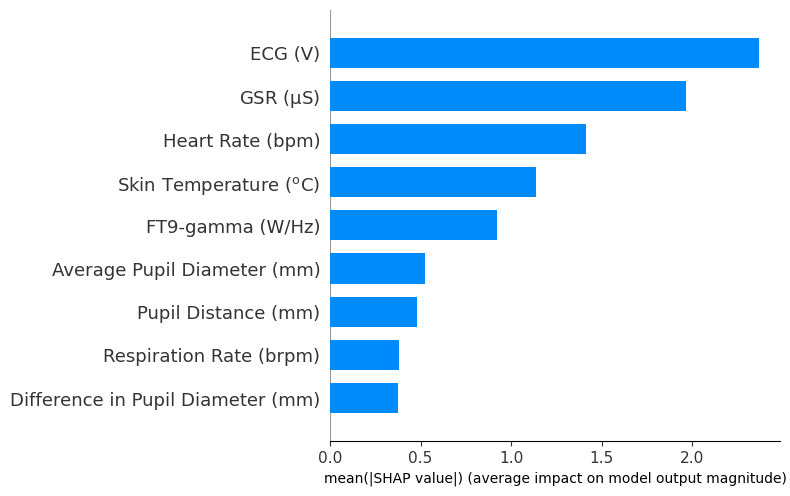

In [14]:
## these changes were necessary as the xlabel went beyond the figure, so fontsize needs to be adjusted

shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=9, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontsize=10)

plt.show()

In [15]:
## steps to convert train and test to pandas dataframe. This step is necessary to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['Actual'])
df2=pd.DataFrame(train_prediction_RF, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['Actual'])
df5=pd.DataFrame(test_prediction_RF, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])
sns_df

,Actual,Estimated,Label
0,4.8,4.744444,Train
1,11.6,11.826667,Train
2,17.1,16.273333,Train
3,15.9,13.116667,Train
4,41.9,33.873333,Train
...,...,...,...
77,0.4,3.696667,Test
78,0.9,2.844444,Test
79,13.8,15.983333,Test
80,49.9,24.345556,Test


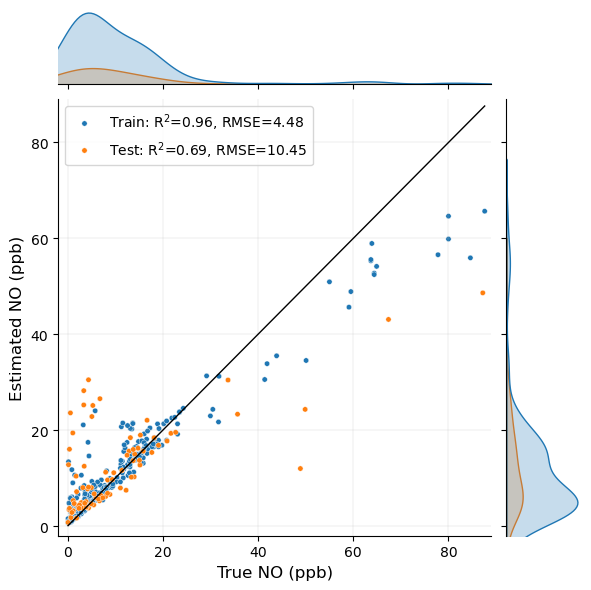

In [16]:
## scatter plot in seaborn

g=sns.jointplot(data=sns_df, x='Actual', y='Estimated', kind="scatter", hue='Label',
                  xlim=[-2, 89], ylim=[-2, 89],s=15)
plt.grid(axis='both',linewidth=0.15)


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))

g.ax_joint.plot([p1, p2], [p1, p2], color='k',linewidth=1)

# Customize the legend
handles, labels = g.ax_joint.get_legend_handles_labels()


g.ax_joint.legend(handles=handles, labels=[ f'Train: R$^2$={correlation_train}, RMSE={RF_rmse_train:.2f}', 
                                               f'Test: R$^2$={correlation_test}, RMSE={RF_rmse_test:.2f}'], title=None)


g.set_axis_labels(r'True NO (ppb)', r'Estimated NO (ppb)',fontsize=12)
plt.show()

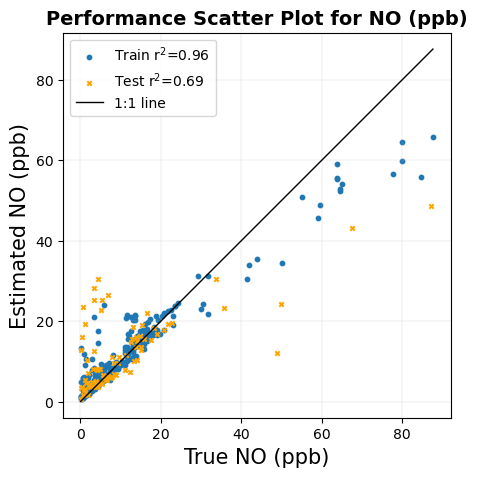

In [17]:
## Optional

import matplotlib as mpl
mpl.rcParams['mathtext.default']='regular'

plt.figure(figsize=(5,5))
plt.scatter(y_train, train_prediction_RF,s=10,c='C0',label='Train $r^2$={}'.format(correlation_train))
plt.scatter(y_test, test_prediction_RF,marker='x',s=10,c='orange',label='Test $r^2$={}'.format(correlation_test))


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))
plt.plot([p1, p2], [p1, p2], 'black',label='1:1 line',linewidth=1)
plt.xlabel('True NO (ppb)', fontsize=15)
plt.ylabel('Estimated NO (ppb)', fontsize=15)
plt.axis('equal')
plt.title("Performance Scatter Plot for NO (ppb)", fontsize=14,fontweight="bold")
plt.legend()
plt.grid(axis='both',linewidth=0.15)
plt.show()

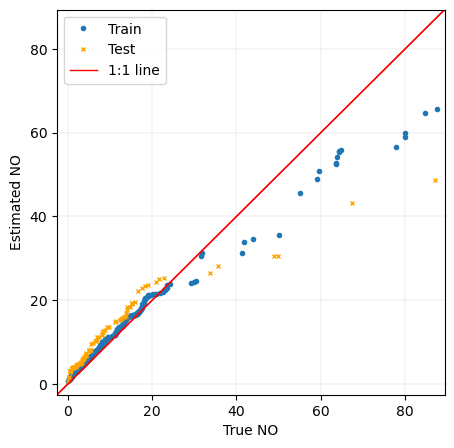

In [20]:
## Lets plot the quantile quantile 

fig, ax = plt.subplots(figsize=(5,5))

pp_x = sm.ProbPlot(y_train, fit=False)
pp_y = sm.ProbPlot(train_prediction_RF, fit=False)


qq = pp_y.qqplot(marker='o',markersize=3,other=pp_x,ax=ax, label='Train')
sm.qqline(ax=ax, line='45', fmt='r',linewidth=1)

pp_xx = sm.ProbPlot(y_test, fit=False)
pp_yy = sm.ProbPlot(test_prediction_RF, fit=False)

qqq = pp_yy.qqplot(xlabel='True NO',ylabel='Estimated NO',
                    marker='x',markersize=3,other=pp_xx,ax=ax,markeredgecolor = 'orange', markerfacecolor = 'orange', label='Test')
sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1, label='1:1 line')
plt.grid(axis='both',linewidth=0.15)
plt.legend()
plt.show()

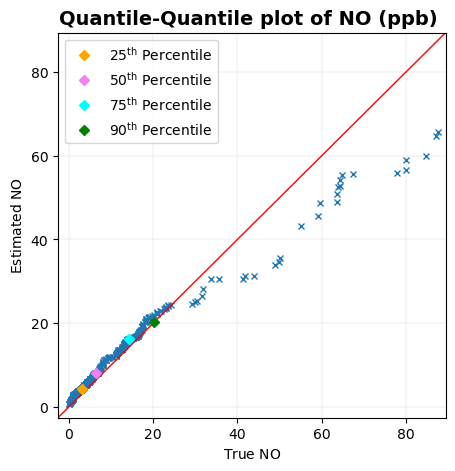

In [19]:
## Optional. qq plot of the entire distribution

all_preds_NO=np.concatenate((train_prediction_RF,test_prediction_RF)) ## the list of all predictions and target values

preds=np.sort(all_preds_NO)
tars=target.sort_values()

plt.rc("figure", figsize=(5,5)) ## to make same figure size in statsmodels.api

pp_x = sm.ProbPlot(preds, fit=False)
pp_y = sm.ProbPlot(tars, fit=False)
qq = pp_x.qqplot(xlabel=r'True $\mathrm{NO}$',ylabel=r'Estimated $\mathrm{NO}$',marker='x',markersize=4,other=pp_y)

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1)
tars_25=np.percentile(tars,25)  ## for the percentiles                                                        
tars_50=np.percentile(tars,50)
tars_75=np.percentile(tars,75)
tars_90=np.percentile(tars,90)


preds_25=np.percentile(preds,25)
preds_50=np.percentile(preds,50)
preds_75=np.percentile(preds,75)  
preds_90=np.percentile(tars,90)  ## end of percentiles

plt.plot(tars_25,preds_25,marker="D",markersize=5,color="orange",linestyle ='None',label=r"$\mathrm{25^{th}}$ Percentile")
plt.plot(tars_50,preds_50,marker="D",markersize=5,color="violet",linestyle ='None',label=r"$\mathrm{50^{th}}$ Percentile")
plt.plot(tars_75,preds_75,marker="D",markersize=5,color="Cyan",linestyle ='None',label=r"$\mathrm{75^{th}}$ Percentile")
plt.plot(tars_90,preds_90,marker="D",markersize=5,color="Green",linestyle ='None',label=r"$\mathrm{90^{th}}$ Percentile")


plt.grid(axis='both',linewidth=0.15)

plt. title('Quantile-Quantile plot of NO (ppb) ',fontsize=14,fontweight="bold")

plt.legend()
plt.show()

In [19]:
## lets calculate the average values RMSE

j_train=[]
j_test=[]
k_train=[]
k_test=[]
for i in range(0,100):
    X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)
    final_model.fit(X_train,y_train)

    train_prediction=final_model.predict(X_train)
    mse_train=mean_squared_error(y_train,train_prediction)
    rmse_train=np.sqrt(mse_train)
    j_train.append(rmse_train)
    
    test_prediction=final_model.predict(X_test)

    mse_test=mean_squared_error(y_test,test_prediction)
    rmse_test=np.sqrt(mse_test)
    j_test.append(rmse_test)

## lets calculate the average correlation    
  
    train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
    correlation_train=int(train_r_sq*100)/100 ## display 
    k_train.append(correlation_train)
    
    test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
    correlation_test=int(test_r_sq*100)/100
    k_test.append(correlation_test)

average_train_rmse=mean(j_train)
average_test_rmse=mean(j_test)
    
average_train_rsq=mean(k_train)
average_test_rsq=mean(k_test)

print('The average train RMSE for NO is:::', '%.2f' % average_train_rmse)
print('The average test RMSE for NO is:::', '%.2f' % average_test_rmse)

print('The average train r square for NO is:::', '%.2f' % average_train_rsq)
print('The average test r square for NO is:::', '%.2f' % average_test_rsq)

The average train RMSE for NO is::: 4.23
The average test RMSE for NO is::: 11.25
The average train r square for NO is::: 0.94
The average test r square for NO is::: 0.42


In [20]:
print('The test RMSE error in each of the trail is:::', j_test)

The test RMSE error in each of the trail is::: [13.271387305686263, 8.331236806523503, 13.717518209603103, 9.9404616262903, 12.674867773490076, 12.550512905082417, 9.946280620904815, 11.05625418453229, 11.322978402386656, 9.380600691890749, 8.090127431143106, 11.8555241952585, 7.714016468495482, 13.188206622641836, 9.939805520446502, 13.854491356073607, 14.09766356012303, 8.316878845054989, 13.454366642299698, 13.13445045583091, 13.01191837867471, 10.17344753730058, 11.527336533526062, 10.84882049864824, 11.351024140898305, 9.906075838085863, 7.984605115174725, 9.940303939827926, 10.550606185083083, 13.001229765649374, 7.447047765848506, 10.4081109502075, 11.452316728957763, 11.624938308746618, 13.169075557836939, 9.47661559525572, 13.325941573005814, 13.945343149604225, 8.683886901101838, 10.615502054993593, 13.865141104330233, 8.51634407066967, 12.682453184936648, 9.632408376905628, 11.129706751322194, 8.597564098176653, 11.34921230024921, 10.373186506764249, 11.3632604297919, 12.504

In [21]:
test_rmse=pd.DataFrame(j_test, columns=['Test RMSE Error for NO (ppb)'])
test_rmse.head()

,Test RMSE Error for NO (ppb)
0,13.271387
1,8.331237
2,13.717518
3,9.940462
4,12.674868


In [22]:
print('The r^2 in each of the trail in test set is:::', k_test)

The r^2 in each of the trail in test set is::: [0.35, 0.44, 0.23, 0.46, 0.27, 0.46, 0.63, 0.41, 0.46, 0.15, 0.58, 0.25, 0.51, 0.18, 0.31, 0.37, 0.19, 0.68, 0.47, 0.28, 0.34, 0.5, 0.27, 0.4, 0.36, 0.52, 0.52, 0.61, 0.4, 0.44, 0.58, 0.4, 0.27, 0.43, 0.5, 0.69, 0.23, 0.27, 0.61, 0.54, 0.45, 0.55, 0.2, 0.61, 0.35, 0.62, 0.25, 0.63, 0.45, 0.32, 0.47, 0.56, 0.5, 0.5, 0.61, 0.42, 0.46, 0.49, 0.25, 0.37, 0.53, 0.11, 0.27, 0.49, 0.58, 0.17, 0.47, 0.84, 0.2, 0.42, 0.5, 0.6, 0.14, 0.52, 0.26, 0.34, 0.55, 0.36, 0.38, 0.34, 0.17, 0.4, 0.57, 0.39, 0.26, 0.45, 0.59, 0.31, 0.26, 0.37, 0.19, 0.46, 0.41, 0.52, 0.4, 0.36, 0.39, 0.48, 0.46, 0.42]


In [23]:
test_r2=pd.DataFrame(k_test, columns=['Test R$^2$ for NO (ppb)'])
test_r2.head()

,Test R$^2$ for NO (ppb)
0,0.35
1,0.44
2,0.23
3,0.46
4,0.27


In [24]:
combined_NO_PB=pd.concat([test_rmse,test_r2], axis=1)
combined_NO_PB.head()

,Test RMSE Error for NO (ppb),Test R$^2$ for NO (ppb)
0,13.271387,0.35
1,8.331237,0.44
2,13.717518,0.23
3,9.940462,0.46
4,12.674868,0.27


In [25]:
#combined_NO_PB.to_csv('../errors/NO_PB.csv')